In [17]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
from haversine import haversine, Unit
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [18]:
#Data preprocessing
childcare = pd.read_csv(r'project1_new_datasets\new_child_care.csv')
employment = pd.read_csv(r'project1_new_datasets\new_employment.csv')
income = pd.read_csv(r'project1_new_datasets\new_income.csv')
population = pd.read_csv(r'project1_new_datasets\new_population.csv')
potential_loc = pd.read_csv(r'project1_new_datasets\new_potential_loc.csv')


population = population.iloc[:, :5].drop(['Total'], axis=1)
population['2w-12yrs'] = np.floor(population.iloc[:, 1:3].sum(axis=1)+3/5*population.iloc[:, 3]).astype(int)
print(population)
demand_desert = pd.merge(population, employment, on='zip_code', how = 'outer')
demand_desert = pd.merge(demand_desert, income, on='zip_code', how = 'outer')
demand_desert['high_demand'] = (demand_desert['employment rate'] >= 0.6)|(demand_desert['average income'] <= 60000)
demand_desert['high_demand'] = demand_desert['high_demand'].astype(int)
#Data cleaning
childcare=childcare[childcare['total_capacity']>0].reset_index(drop=True)
childcare_capacity = childcare.groupby('zip_code')[['infant_capacity','toddler_capacity',
                                                    'preschool_capacity','school_age_capacity'
                                                   ,'children_capacity']].sum().reset_index()
childcare_capacity['2w_5yr_cap'] = np.floor(childcare_capacity.iloc[:, 1:4].sum(axis=1)+childcare_capacity['children_capacity']*5/12).astype(int)
childcare_capacity['2w_12yr_cap'] = np.floor(childcare_capacity.iloc[:, 1:6].sum(axis=1)).astype(int)

demand_desert = pd.merge(demand_desert, childcare_capacity, on='zip_code', how = 'outer')

demand_desert.reset_index(drop=True, inplace=True)

#def classify_desert(row):
#    if row['high_demand'] == 1:
#        return row['2w_12yr_cap'] <= row['2w-12yrs']*0.5
#    else:
#        return row['2w_12yr_cap'] <= row['2w-12yrs']*1/3
#
#demand_desert['desert'] = demand_desert.apply(classify_desert, axis=1).astype(int)

demand_desert.to_csv(r'project1_new_datasets\demand_desert.csv', index=False)

      zip_code    -5   5-9  10-14  2w-12yrs
0        10001   744   784    942      2093
1        10002  2142  3046   3198      7106
2        10003  1440  1034    953      3045
3        10004   433   182    161       711
4        10005   484   204    229       825
...        ...   ...   ...    ...       ...
1018     14767   101   219    168       420
1019     14770   137   197    223       467
1020     14772   256   253    224       643
1021     14805    31    16     29        64
1022     14806   127   111    154       330

[1023 rows x 5 columns]


In [19]:
childcare.head()

,zip_code,facility_id,program_type,facility_status,facility_name,city,school_district_name,infant_capacity,toddler_capacity,preschool_capacity,school_age_capacity,children_capacity,total_capacity,latitude,longitude
0,10001,837597,SACC,Registration,I Have a Dream Foundation,New York,Manhattan 2,0,0,0,84,0,84,40.748836,-73.999810
1,10001,661697,GFDC,License,Chelsea Little Angels Day Care,New York,Manhattan 2,0,0,0,4,12,16,40.748911,-74.001546
2,10001,837329,SACC,Registration,Bright Horizons at Hudson Yards,New York,Manhattan 2,0,0,0,17,0,17,40.752093,-74.002588
3,10001,350076,FDC,Registration,GRAMMAS HANDS,New York,Manhattan 2,0,0,0,2,6,8,40.748296,-74.001263
4,10001,292419,SACC,Registration,The Hudson Guild @26th Street,New York,Manhattan 2,0,0,0,79,0,79,40.749247,-74.001598


In [20]:
demand_desert.head()

,zip_code,-5,5-9,10-14,2w-12yrs,employment rate,average income,high_demand,infant_capacity,toddler_capacity,preschool_capacity,school_age_capacity,children_capacity,2w_5yr_cap,2w_12yr_cap
0,10001,744,784,942,2093,0.595097,102878.033603,0,0,0,0,585,24,10,609
1,10002,2142,3046,3198,7106,0.520662,59604.041165,1,0,0,18,4508,203,102,4729
2,10003,1440,1034,953,3045,0.497244,114273.049645,0,0,0,0,1995,0,0,1995
3,10004,433,182,161,711,0.506661,132004.310345,0,0,0,0,263,0,0,263
4,10005,484,204,229,825,0.665833,121437.713311,1,0,0,0,39,0,0,39


# The Problem of Budgeting

In [21]:
#Problem 1
m1=Model("Budgeting")
x={}
y={}
#Decision variables
for i in range(len(childcare)):
    x[1,i]=m1.addVar(vtype=GRB.INTEGER,name=f"new slots at facility {i}")
    x[2,i]=m1.addVar(vtype=GRB.INTEGER,name=f"new slots for children under 5 at facility {i}")
for j in range(len(demand_desert)):
    y[1,j]=m1.addVar(vtype=GRB.INTEGER,name=f"newly built small facilities in {j}")
    y[2,j]=m1.addVar(vtype=GRB.INTEGER,name=f"newly built medium facilities in {j}")
    y[3,j]=m1.addVar(vtype=GRB.INTEGER,name=f"newly built large facilities in {j}")
#Objective function
m1.setObjective(
    quicksum(65000*y[1,j]+95000*y[2,j]+115000*y[3,j] for j in range(len(demand_desert)))+
        quicksum(200*x[1,i]+100*x[2,i]+20000*(x[1,i]/childcare["total_capacity"][i])
            for i in range(len(childcare))),GRB.MINIMIZE
)
#Constraints
for i in range(len(childcare)):
    m1.addConstr(x[1,i]<=0.2*childcare["total_capacity"][i],f"Maximum expansion rate {i}")
    m1.addConstr(x[2,i]-x[1,i]<=0)
    m1.addConstr(childcare["total_capacity"][i]+x[1,i]<=
                 max(childcare["total_capacity"][i],500),f"Maximum slots {i}")
    m1.addConstr(x[1,i]>=0,f"non-negativity {i}_1")
    m1.addConstr(x[2,i]>=0,f"non-negativity {i}_2")
    
care_reg=childcare.groupby("zip_code")
for j in range(len(demand_desert)):
    m1.addConstr(y[1,j]>=0,f"non-negativity {j}_y_1")
    m1.addConstr(y[2,j]>=0,f"non-negativity {j}_y_2")
    m1.addConstr(y[3,j]>=0,f"non-negativity {j}_y_3")
    jcare=care_reg.get_group(demand_desert.iloc[j,0]).index
    #high demand or not(changing greater than to greater than or equal)
    if demand_desert["high_demand"][j]==1:
        m1.addConstr(demand_desert["2w_12yr_cap"][j]+100*y[1,j]+200*y[2,j]+400*y[3,j]+
                         quicksum(x[1,l] for l in jcare)>=int(1/2*(demand_desert["2w-12yrs"][j]))+1)
    else:
        m1.addConstr(demand_desert["2w_12yr_cap"][j]+100*y[1,j]+200*y[2,j]+400*y[3,j]+
                         quicksum(x[1,l] for l in jcare)>=int(1/3*(demand_desert["2w-12yrs"][j]))+1)
    m1.addConstr(demand_desert["2w_5yr_cap"][j]+50*y[1,j]+100*y[2,j]+200*y[3,j]+
                         quicksum(x[2,l] for l in jcare)>=2/3*(demand_desert["-5"][j]))
m1.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10875H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 78890 rows, 32579 columns and 127247 nonzeros
Model fingerprint: 0xc733106a
Variable types: 0 continuous, 32579 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+02, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+04]
Found heuristic solution: objective 3.605250e+08
Presolve removed 78600 rows and 32000 columns
Presolve time: 0.84s
Presolved: 290 rows, 579 columns, 1158 nonzeros
Found heuristic solution: objective 3.159789e+08
Variable types: 0 continuous, 579 integer (88 binary)
Found heuristic solution: objective 3.159489e+08

Root relaxation: objective 3.157883e+08, 289 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node   

In [22]:
# Initialize lists to store results for CSV
facility_expansion_data = []
new_facilities_data = []

# Assuming the optimization model has been solved, let's collect the data
if m1.status == GRB.OPTIMAL:
    # Gather facility expansion data
    for i in range(len(childcare)):
        facility_expansion_data.append({
            "Facility ID": i,
            "Expanded Slots": x[1, i].x,
            "Slots for Children Under 5": x[2, i].x
        })
    
    # Gather data on new facilities
    for j in range(len(demand_desert)):
        new_facilities_data.append({
            "Region Zip Code": demand_desert['zip_code'][j],
            "Small Facilities": y[1, j].x,
            "Medium Facilities": y[2, j].x,
            "Large Facilities": y[3, j].x
        })

    # Create DataFrames
    facility_expansion_df = pd.DataFrame(facility_expansion_data)
    new_facilities_df = pd.DataFrame(new_facilities_data)
    
    # Save to CSV files
    facility_expansion_df.to_csv("facility_expansion_p1.csv", index=False)
    new_facilities_df.to_csv("new_facilities_p1.csv", index=False)
else:
    print("No optimal solution found")

In [23]:
facility_expansion_df

,Facility ID,Expanded Slots,Slots for Children Under 5
0,0,11.0,11.0
1,1,-0.0,0.0
2,2,-0.0,0.0
3,3,-0.0,0.0
4,4,0.0,-0.0
...,...,...,...
14750,14750,0.0,-0.0
14751,14751,0.0,0.0
14752,14752,0.0,0.0
14753,14753,-0.0,0.0


In [24]:
new_facilities_df

,Region Zip Code,Small Facilities,Medium Facilities,Large Facilities
0,10001,-0.0,-0.0,2.0
1,10002,-0.0,-0.0,3.0
2,10003,-0.0,-0.0,4.0
3,10004,1.0,-0.0,1.0
4,10005,0.0,0.0,2.0
...,...,...,...,...
1018,14767,0.0,1.0,-0.0
1019,14770,0.0,1.0,-0.0
1020,14772,0.0,0.0,1.0
1021,14805,1.0,-0.0,-0.0


# The Problem of Realistic Capacity Expansion and Distance

In [25]:
#Problem 2
m2=Model("Realistic Capacity Expansion and Distance")
x={}
y={}
a={}
#Decision variables
#a:at the upper bound of section 1 and 2
for i in range(len(childcare)):
    x[1,i]=m2.addVar(vtype=GRB.INTEGER,name=f"new slots at facility {i} between 0% and 10%")
    x[2,i]=m2.addVar(vtype=GRB.INTEGER,name=f"new slots at facility {i} between 10% and 15%")
    x[3,i]=m2.addVar(vtype=GRB.INTEGER,name=f"new slots at facility {i} between 15% and 20%")
    x[4,i]=m2.addVar(vtype=GRB.INTEGER,name=f"new slots for children under 5 at facility {i}")
    a[1,i]=m2.addVar(vtype=GRB.BINARY,name=f"10%")
    a[2,i]=m2.addVar(vtype=GRB.BINARY,name=f"15%")
for j in range(len(potential_loc)):
    y[1,j]=m2.addVar(vtype=GRB.BINARY,name=f"build a small facility in {j}")
    y[2,j]=m2.addVar(vtype=GRB.BINARY,name=f"build a medium facility in {j}")
    y[3,j]=m2.addVar(vtype=GRB.BINARY,name=f"build a large facility in {j}")
#Objective function
m2.setObjective(
    quicksum(65000*y[1,j]+95000*y[2,j]+115000*y[3,j] for j in range(len(potential_loc)))+
        quicksum(200*x[1,i]+400*x[2,i]+1000*x[3,i]+100*x[4,i]+20000*((x[1,i]+x[2,i]+x[3,i])/childcare["total_capacity"][i])
            for i in range(len(childcare))),GRB.MINIMIZE
)
#Constraints
for i in range(len(childcare)):
    m2.addConstr(x[1,i]+x[2,i]+x[3,i]<=0.2*childcare["total_capacity"][i],f"Maximum expansion rate {i}")
    m2.addConstr(x[4,i]-x[1,i]-x[2,i]-x[3,i]<=0)
    m2.addConstr(childcare["total_capacity"][i]+x[1,i]+x[2,i]+x[3,i]<=
                 max(childcare["total_capacity"][i],500),f"Maximum slots {i}")
    
care_reg=childcare.groupby("zip_code")
new_pos=potential_loc.groupby("zip_code")
for j in range(len(demand_desert)):
    jcare=care_reg.get_group(demand_desert.iloc[j,0]).index
    jpos=new_pos.get_group(demand_desert.iloc[j,0]).index
    #high demand or not(changing greater than to greater than or equal)
    if demand_desert["high_demand"][j]==1:
        m2.addConstr(demand_desert["2w_12yr_cap"][j]+quicksum(100*y[1,k]+200*y[2,k]+400*y[3,k] for k in jpos)+
                         quicksum(x[1,l]+x[2,l]+x[3,l] for l in jcare)>=int(1/2*(demand_desert["2w-12yrs"][j]))+1)
    else:
        m2.addConstr(demand_desert["2w_12yr_cap"][j]+quicksum(100*y[1,k]+200*y[2,k]+400*y[3,k] for k in jpos)+
                         quicksum(x[1,l]+x[2,l]+x[3,l] for l in jcare)>=int(1/3*(demand_desert["2w-12yrs"][j]))+1)
    m2.addConstr(demand_desert["2w_5yr_cap"][j]+quicksum(50*y[1,k]+100*y[2,k]+200*y[3,k] for k in jpos)+
                         quicksum(x[4,l] for l in jcare)>=2/3*(demand_desert["-5"][j]))
    
#Only one type at most
for j in range(len(potential_loc)):
    m2.addConstr(y[1,j]+y[2,j]+y[3,j]<=1,f"One type for {j}")
    
#piecewise
for i in range(len(childcare)):
    # Constraints for x[1,i]
    m2.addConstr(x[1,i]>=a[1,i]*int(0.1*childcare["total_capacity"][i]), f"200_1")
    m2.addConstr(x[1,i]<=int(0.1*childcare["total_capacity"][i]),f"200_2")
    m2.addConstr(x[2,i]>=(int(0.15*childcare["total_capacity"][i])-int(0.1*childcare["total_capacity"][i]))*a[2,i],f"400_1")
    m2.addConstr(x[2,i]<=(int(0.15*childcare["total_capacity"][i])-int(0.1*childcare["total_capacity"][i]))*a[1,i],f"400_2")
    m2.addConstr(x[3,i]>=0,f"1000_1")
    m2.addConstr(x[3,i]<=(int(0.2*childcare["total_capacity"][i])-int(0.15*childcare["total_capacity"][i]))*a[2,i],f"1000_2")
    
#Distance
for j in range(len(demand_desert)):
    jcare=care_reg.get_group(demand_desert.iloc[j,0]).index
    jpos=new_pos.get_group(demand_desert.iloc[j,0]).index
    #between original and new facilities
    for k in jcare:
        if np.isnan(childcare["latitude"][k]) or np.isnan(childcare["longitude"][k]):
            continue
        for l in jpos:
            dist0=haversine((childcare["latitude"][k],childcare["longitude"][k]),
                            (potential_loc["latitude"][l],potential_loc["longitude"][l]),
                            unit=Unit.MILES)
            if dist0<0.06:
                m2.addConstr(y[1,l]+y[2,l]+y[3,l]==0)
    #between new facilities
    for k in jpos:
        for l in jpos:
            if l>k:
                dist1=haversine((potential_loc["latitude"][k],potential_loc["longitude"][k]),
                                (potential_loc["latitude"][l],potential_loc["longitude"][l]),
                                unit=Unit.MILES)
                #Can't be chosen at the same time if dist1<0.06
                if dist1<0.06:
                    m2.addConstr(y[1,k]+y[2,k]+y[3,k]+y[1,l]+y[2,l]+y[3,l]<=1)
m2.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10875H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 282106 rows, 395430 columns and 1519042 nonzeros
Model fingerprint: 0x40b707a9
Variable types: 0 continuous, 395430 integer (336410 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+02, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 1e+04]
Presolve removed 277075 rows and 387646 columns (presolve time = 50s) ...
Presolve removed 277070 rows and 387643 columns
Presolve time: 49.96s
Presolved: 5036 rows, 7787 columns, 21580 nonzeros
Variable types: 0 continuous, 7787 integer (5686 binary)
Found heuristic solution: objective 3.320767e+08
Found heuristic solution: objective 3.311750e+08
Found heuristic solution: objective 3.293641e+08

Root simplex log...

Iteration

In [26]:
facility_expansion_data_p2 = []
new_facilities_data_p2 = []

# Assuming the optimization model has been solved, let's collect the data for Problem 2
if m2.status == GRB.OPTIMAL:
    # Gather facility expansion data
    for i in range(len(childcare)):
        facility_expansion_data_p2.append({
            "Facility ID": i,
            "Expanded Slots": x[1, i].x + x[2, i].x + x[3, i].x,
            "Slots for Children Under 5": x[4, i].x
        })
    
    # Gather data on new facilities
    for j in range(len(potential_loc)):
        small_facility = int(y[1, j].x)
        medium_facility = int(y[2, j].x)
        large_facility = int(y[3, j].x)
        
        if small_facility == 1 or medium_facility == 1 or large_facility == 1:
            new_facilities_data_p2.append({
                "Region Zip Code": potential_loc['zip_code'][j],
                "Longitude": potential_loc['longitude'][j],
                "Latitude": potential_loc['latitude'][j],
                "Small Facility": small_facility,
                "Medium Facility": medium_facility,
                "Large Facility": large_facility
            })

    # Create DataFrames
    facility_expansion_df_p2 = pd.DataFrame(facility_expansion_data_p2)
    new_facilities_df_p2 = pd.DataFrame(new_facilities_data_p2)
    
    # Save to CSV files
    facility_expansion_df_p2.to_csv("facility_expansion_p2.csv", index=False)
    new_facilities_df_p2.to_csv("new_facilities_p2.csv", index=False)
else:
    print("No optimal solution found")

In [27]:
facility_expansion_df_p2

,Facility ID,Expanded Slots,Slots for Children Under 5
0,0,12.0,12.0
1,1,0.0,-0.0
2,2,0.0,-0.0
3,3,0.0,0.0
4,4,11.0,11.0
...,...,...,...
14750,14750,0.0,0.0
14751,14751,0.0,0.0
14752,14752,0.0,0.0
14753,14753,0.0,-0.0


In [28]:
new_facilities_df_p2

,Region Zip Code,Longitude,Latitude,Small Facility,Medium Facility,Large Facility
0,10001,-74.004994,40.740011,0,0,1
1,10001,-73.995710,40.744408,0,0,1
2,10002,-73.993451,40.707449,0,0,1
3,10002,-73.987162,40.720105,0,0,1
4,10002,-73.983491,40.723590,0,0,1
...,...,...,...,...,...,...
2751,14767,-79.482863,42.064277,0,1,0
2752,14770,-78.327679,42.022032,0,1,0
2753,14772,-78.966816,42.169988,0,0,1
2754,14805,-76.724885,42.358652,1,0,0


# The Problem of Fairness

In [29]:
# Problem 3
m3=Model("Fairness")
x={}
y={}
a={}
# Decision variables
for i in range(len(childcare)):
    x[1, i] = m3.addVar(vtype=GRB.INTEGER, name=f"new slots at facility {i} between 0% and 10%")
    x[2, i] = m3.addVar(vtype=GRB.INTEGER, name=f"new slots at facility {i} between 10% and 15%")
    x[3, i] = m3.addVar(vtype=GRB.INTEGER, name=f"new slots at facility {i} between 15% and 20%")
    x[4, i] = m3.addVar(vtype=GRB.INTEGER, name=f"new slots for children under 5 at facility {i}")
    a[1, i] = m3.addVar(vtype=GRB.BINARY, name=f"10%")
    a[2, i] = m3.addVar(vtype=GRB.BINARY, name=f"15%")

# Decision Variables for New Facilities
for j in range(len(potential_loc)):
    y[1, j] = m3.addVar(vtype=GRB.BINARY, name=f"build a small facility in {j}")
    y[2, j] = m3.addVar(vtype=GRB.BINARY, name=f"build a medium facility in {j}")
    y[3, j] = m3.addVar(vtype=GRB.BINARY, name=f"build a large facility in {j}")

# Define the minimum and maximum slot ratio variables
min_ratio = m3.addVar(lb=0, vtype=GRB.CONTINUOUS, name="min_slot_ratio")
max_ratio = m3.addVar(lb=0, vtype=GRB.CONTINUOUS, name="max_slot_ratio")

# Objective Function: Maximize the Social Coverage Index
m3.setObjective(
        2 * (
            (demand_desert['2w_5yr_cap'].sum()+
            (quicksum(x[4, i] for i in range(len(childcare))) + quicksum(50 * y[1, j] + 100 * y[2, j] + 200 * y[3, j] for j in range(len(potential_loc))))) / demand_desert["-5"].sum()
        ) +
        (
            (demand_desert['2w_12yr_cap'].sum()+
            (quicksum(x[1, i] + x[2, i] + x[3, i] for i in range(len(childcare))) + quicksum(100 * y[1, j] + 200 * y[2, j] + 400 * y[3, j] for j in range(len(potential_loc))))) / demand_desert["2w-12yrs"].sum()
        ),
    GRB.MAXIMIZE
)

# Fairness Constraint: Calculate slot ratio dynamically using decision variables
care_reg=childcare.groupby("zip_code")
new_pos=potential_loc.groupby("zip_code")
# Calculate the slot ratios for each zip code and constrain them between min_ratio and max_ratio
for i in range(len(demand_desert)):
    # Calculate the slot ratio for zip code i
    if demand_desert["2w-12yrs"][i] > 0:
        slots_ratio_i = (
            quicksum(x[1, l] + x[2, l] + x[3, l] for l in care_reg.get_group(demand_desert.iloc[i, 0]).index) +
            quicksum(100 * y[1, k] + 200 * y[2, k] + 400 * y[3, k] for k in new_pos.get_group(demand_desert.iloc[i, 0]).index)
        ) / demand_desert["2w-12yrs"][i]
        
        # Constrain each slot ratio to be within min_ratio and max_ratio
        m3.addConstr(slots_ratio_i >= min_ratio, f"Min ratio constraint for zip {demand_desert.iloc[i,0]}")
        m3.addConstr(slots_ratio_i <= max_ratio, f"Max ratio constraint for zip {demand_desert.iloc[i,0]}")
    else:
        print(f"Skipping zip code {demand_desert.iloc[i,0]} due to zero population.")

# Enforce fairness by limiting the difference between max_ratio and min_ratio to 0.1
m3.addConstr(max_ratio - min_ratio <= 0.1, "Fairness constraint")

# Budget Constraint
m3.addConstr(
    quicksum(65000 * y[1, j] + 95000 * y[2, j] + 115000 * y[3, j] for j in range(len(potential_loc))) +
    quicksum(200 * x[1, i] + 400 * x[2, i] + 1000 * x[3, i] + 100 * x[4, i] + 20000 * ((x[1, i] + x[2, i] + x[3, i]) / childcare["total_capacity"][i]) for i in range(len(childcare))) <= 1000000000,
    "Budget constraint"
)

# Constraint from Problem 2
for i in range(len(childcare)):
    m3.addConstr(x[1,i]+x[2,i]+x[3,i]<=0.2*childcare["total_capacity"][i],f"Maximum expansion rate {i}")
    m3.addConstr(x[4,i]-x[1,i]-x[2,i]-x[3,i]<=0)
    m3.addConstr(childcare["total_capacity"][i]+x[1,i]+x[2,i]+x[3,i]<=
                 max(childcare["total_capacity"][i],500),f"Maximum slots {i}")
    
care_reg=childcare.groupby("zip_code")
new_pos=potential_loc.groupby("zip_code")
for j in range(len(demand_desert)):
    jcare=care_reg.get_group(demand_desert.iloc[j,0]).index
    jpos=new_pos.get_group(demand_desert.iloc[j,0]).index
    #high demand or not(changing greater than to greater than or equal)
    if demand_desert["high_demand"][j]==1:
        m3.addConstr(demand_desert["2w_12yr_cap"][j]+quicksum(100*y[1,k]+200*y[2,k]+400*y[3,k] for k in jpos)+
                         quicksum(x[1,l]+x[2,l]+x[3,l] for l in jcare)>=int(1/2*(demand_desert["2w-12yrs"][j]))+1)
    else:
        m3.addConstr(demand_desert["2w_12yr_cap"][j]+quicksum(100*y[1,k]+200*y[2,k]+400*y[3,k] for k in jpos)+
                         quicksum(x[1,l]+x[2,l]+x[3,l] for l in jcare)>=int(1/3*(demand_desert["2w-12yrs"][j]))+1)
    m3.addConstr(demand_desert["2w_5yr_cap"][j]+quicksum(50*y[1,k]+100*y[2,k]+200*y[3,k] for k in jpos)+
                         quicksum(x[4,l] for l in jcare)>=2/3*(demand_desert["-5"][j]))
    
#Only one type at most
for j in range(len(potential_loc)):
    m3.addConstr(y[1,j]+y[2,j]+y[3,j]<=1,f"One type for {j}")
    
#piecewise
for i in range(len(childcare)):
    # Constraints for x[1,i]
    m3.addConstr(x[1,i]>=a[1,i]*int(0.1*childcare["total_capacity"][i]), f"200_1")
    m3.addConstr(x[1,i]<=int(0.1*childcare["total_capacity"][i]),f"200_2")
    m3.addConstr(x[2,i]>=(int(0.15*childcare["total_capacity"][i])-int(0.1*childcare["total_capacity"][i]))*a[2,i],f"400_1")
    m3.addConstr(x[2,i]<=(int(0.15*childcare["total_capacity"][i])-int(0.1*childcare["total_capacity"][i]))*a[1,i],f"400_2")
    m3.addConstr(x[3,i]>=0,f"1000_1")
    m3.addConstr(x[3,i]<=(int(0.2*childcare["total_capacity"][i])-int(0.15*childcare["total_capacity"][i]))*a[2,i],f"1000_2")
    
#Distance
for j in range(len(demand_desert)):
    jcare=care_reg.get_group(demand_desert.iloc[j,0]).index
    jpos=new_pos.get_group(demand_desert.iloc[j,0]).index
    #between original and new facilities
    for k in jcare:
        if np.isnan(childcare["latitude"][k]) or np.isnan(childcare["longitude"][k]):
            continue
        for l in jpos:
            dist0=haversine((childcare["latitude"][k],childcare["longitude"][k]),
                            (potential_loc["latitude"][l],potential_loc["longitude"][l]),
                            unit=Unit.MILES)
            if dist0<0.06:
                m3.addConstr(y[1,l]+y[2,l]+y[3,l]==0)
    #between new facilities
    for k in jpos:
        for l in jpos:
            if l>k:
                dist1=haversine((potential_loc["latitude"][k],potential_loc["longitude"][k]),
                                (potential_loc["latitude"][l],potential_loc["longitude"][l]),
                                unit=Unit.MILES)
                #Can't be chosen at the same time if dist1<0.06
                if dist1<0.06:
                    m3.addConstr(y[1,k]+y[2,k]+y[3,k]+y[1,l]+y[2,l]+y[3,l]<=1)
m3.optimize()

Skipping zip code 11042 due to zero population.
Skipping zip code 12742 due to zero population.
Skipping zip code 13441 due to zero population.
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10875H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 284148 rows, 395432 columns and 2587516 nonzeros
Model fingerprint: 0xca0490b6
Variable types: 2 continuous, 395430 integer (336410 binary)
Coefficient statistics:
  Matrix range     [4e-05, 1e+05]
  Objective range  [4e-07, 5e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+09]
Presolve removed 83711 rows and 24405 columns
Presolve time: 0.25s

Explored 0 nodes (0 simplex iterations) in 0.56 seconds (0.83 work units)
Thread count was 1 (of 16 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -


In [30]:
new_facilities_df_p2['Facility_total'] = new_facilities_df_p2.iloc[:, 3:6].sum(axis=1)
new_facilities_df_p2

,Region Zip Code,Longitude,Latitude,Small Facility,Medium Facility,Large Facility,Facility_total
0,10001,-74.004994,40.740011,0,0,1,1
1,10001,-73.995710,40.744408,0,0,1,1
2,10002,-73.993451,40.707449,0,0,1,1
3,10002,-73.987162,40.720105,0,0,1,1
4,10002,-73.983491,40.723590,0,0,1,1
...,...,...,...,...,...,...,...
2751,14767,-79.482863,42.064277,0,1,0,1
2752,14770,-78.327679,42.022032,0,1,0,1
2753,14772,-78.966816,42.169988,0,0,1,1
2754,14805,-76.724885,42.358652,1,0,0,1


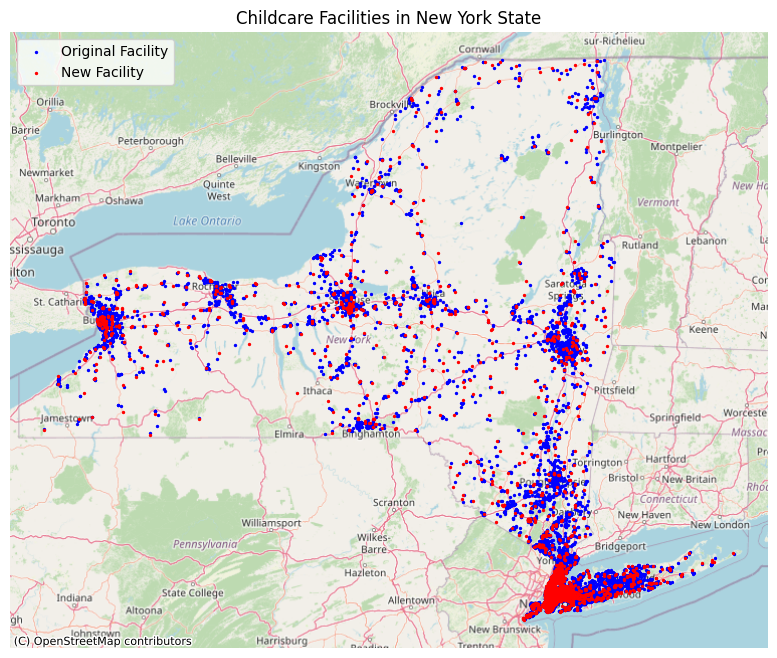

In [31]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Convert the coordinates to a suitable CRS (usually EPSG:3857 for web maps)
gdf = gpd.GeoDataFrame(childcare, geometry=gpd.points_from_xy(childcare.longitude, childcare.latitude), crs="EPSG:4326")
gdf_new = gpd.GeoDataFrame(new_facilities_df_p2, geometry=gpd.points_from_xy(new_facilities_df_p2.Longitude, new_facilities_df_p2.Latitude), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)  # Convert to web map projection
gdf_new = gdf_new.to_crs(epsg=3857)  # Convert to web map projection

# Plot the facilities with contextily basemap
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, marker='o', color='blue', markersize=2, label="Original Facility")
gdf_new.plot(ax=ax, marker='o', color='red', markersize=2, label="New Facility")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Google Maps style basemap

ax.set_axis_off()
plt.title("Childcare Facilities in New York State")
plt.legend()
plt.show()
fig.savefig("childcare_facilities_map.png", dpi=500)

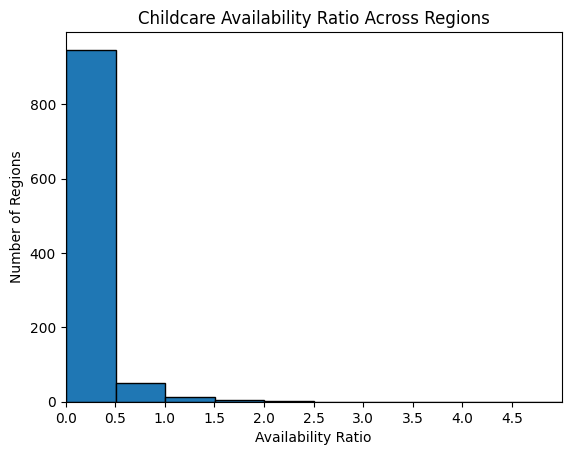

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the availability ratio
demand_desert['availability_ratio'] = demand_desert['2w_12yr_cap'] / demand_desert['2w-12yrs']

# Replace infinite values (where denominator is zero) and drop NaN values
demand_desert['availability_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
demand_desert.dropna(subset=['availability_ratio'], inplace=True)

# Plotting the fairness metric comparison
plt.hist(demand_desert['availability_ratio'], bins=20, edgecolor='black')
plt.title("Childcare Availability Ratio Across Regions")
plt.xlabel("Availability Ratio")
plt.ylabel("Number of Regions")
plt.xticks(np.arange(0, 5, 0.5))
plt.xlim(0, 5)
plt.show()